In [30]:
#here  im going to classify the passengers as survived or perished, based on the available features, and thats going to help us underestand which
#factores helped people survived and make predictions in new data

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler


In [49]:
# Read in the data
data = pd.read_csv('titanic_data.csv')

# Define independent and dependent variables
X = data.drop('Survived', axis=1)
y = data['Survived']

# Ensure categorical variables are encoded correctly
X = pd.get_dummies(X, drop_first=True)

Used random oversampling instead of class weights

In [50]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply random oversampling to the training data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


c:\Users\caspe\Documents\DBM2\env\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\caspe\Documents\DBM2\env\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [51]:
# Hyperparameter optimization
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_model = grid_search.best_estimator_

In [52]:
# Predictions and evaluation
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=["Perished", "Survived"],
    columns=["Perished", "Survived"]
)

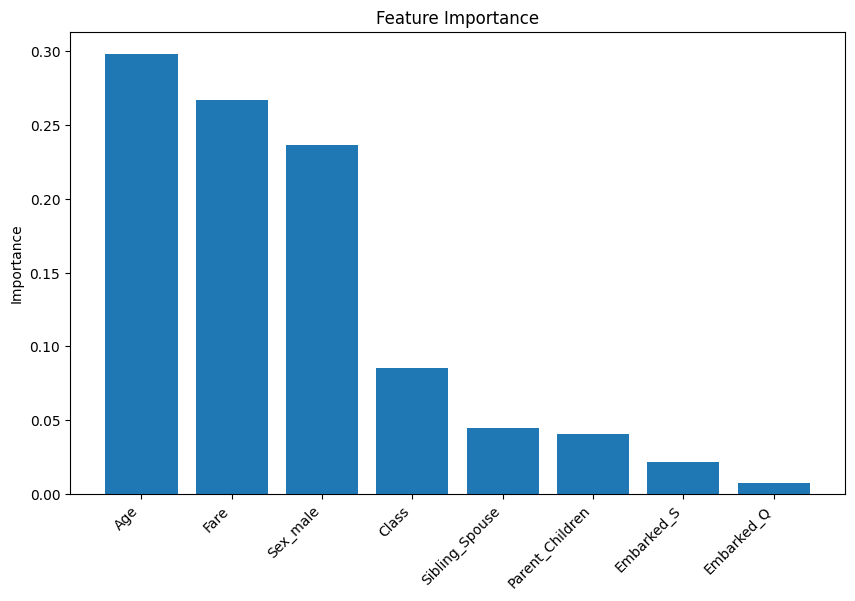

In [53]:
# Importance of features
importances = best_model.feature_importances_
features = X.columns
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance')
plt.ylabel('Importance')
plt.show()

Best set of hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Model accuracy: 0.7905982905982906
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82       137
           1       0.74      0.76      0.75        97

    accuracy                           0.79       234
   macro avg       0.78      0.79      0.79       234
weighted avg       0.79      0.79      0.79       234



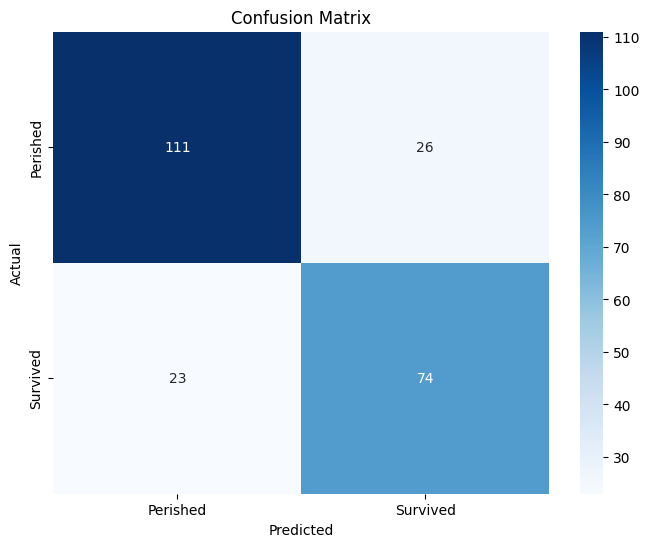

In [54]:
# Results
print(f"Best set of hyperparameters: {grid_search.best_params_}")
print(f"Model accuracy: {accuracy}")
print("Classification Report:\n", report)

# Visualization of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

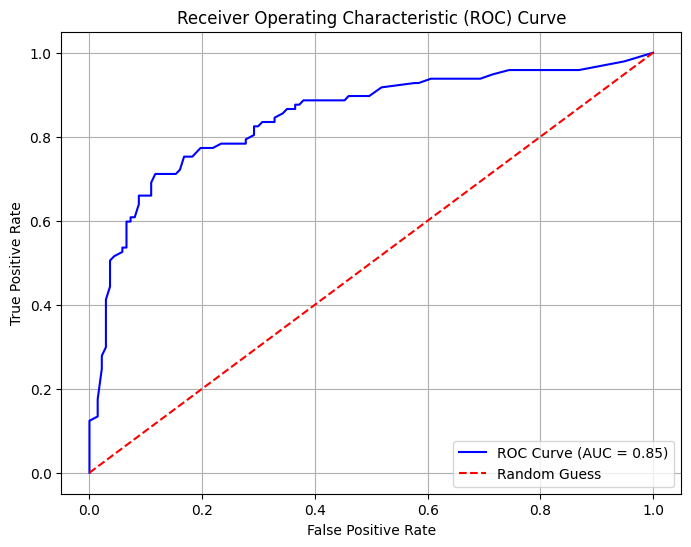

In [57]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()